In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import time


from collections import defaultdict


from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [43]:
def make_epsilon_greedy_policy(Q, epsilon, number_of_actions):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(state):
        action_rewards = [(action, Q[(state, action)]) for action in range(number_of_actions)] # [(action, reward), (action, reward)]
        #print('action_rewards', action_rewards)

        action, reward = sorted(action_rewards, key=lambda x:-x[1])[0]
        #print('action', action, 'reward', reward)

        if np.random.uniform() < epsilon:
            action = np.round(np.random.uniform() * (number_of_actions -1))
            #print('doing random action', action)
        #else:
            #print('doing best action', action)
        return action

    return policy_fn

### TESTING
starting_state = env.reset()
print(starting_state)
q = dict()
q[( starting_state, 0)] = 0.5
q[( starting_state, 1)] = 0.1
q[( (13, 2, True), 1)] = 0.3

fn = make_epsilon_greedy_policy(q, 0.4, 2)
print(fn(starting_state))

(20, 10, False)
0.0


In [9]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    
    return Q, policy

In [10]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [17]:
def sample_episode(env, policy):
    episode = []
    state = env.reset()
    for t in range(100):
        action = policy(state)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state
    return episode

In [11]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    V = defaultdict(float)

    number_of_actions = 2 # Hir or strick
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # Q(s,a)
    N = defaultdict(float) # N(s,a)
    epsilon = 1
    pi_k = sample_policy
    
    for k in range(1, num_episodes + 1):
        episode = sample_episode(pi_k, env)
        for state, action, reward in episode:
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])

            N[(state, action)] += 1.0
            Q[(state, action)] += (1 / N[(state, action)]) * (G - Q[(state, action)])
        
        epsilon = 1/k
        _, pi_k = make_epsilon_greedy_policy(Q, number_of_actions, epsilon=epsilon)

        V[state] = returns_sum[state] / returns_count[state]

    return V    

In [8]:
d = defaultdict(lambda: np.zeros(env.action_space.n))
d[1]

0.0

Episode 3000/10000.

C:\Users\filip\anaconda3\envs\edan95\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Episode 10000/10000.

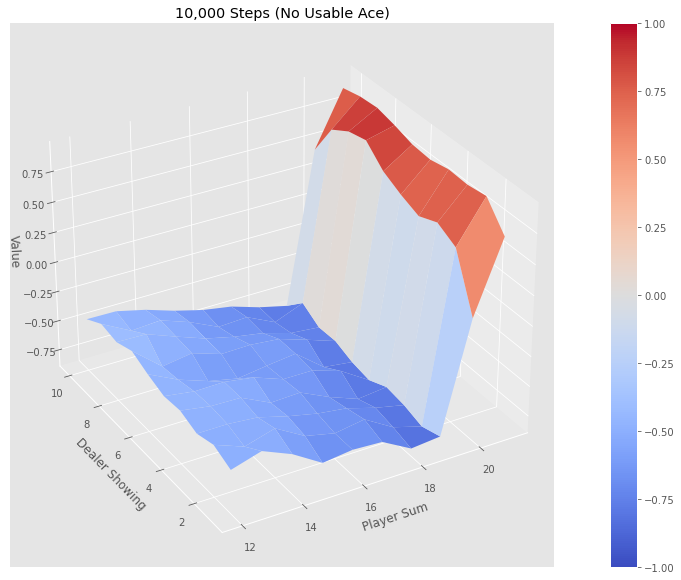

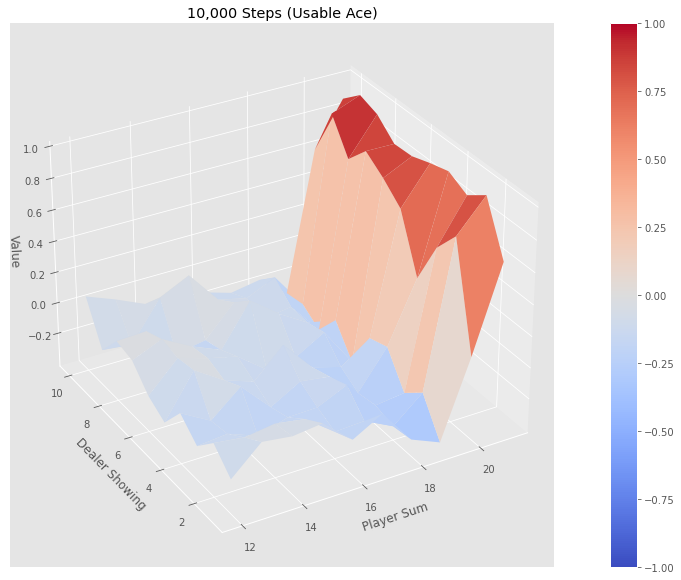


 1.2909730000028503 s
Episode 3000/500000.

C:\Users\filip\anaconda3\envs\edan95\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
C:\Users\filip\anaconda3\envs\edan95\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Episode 500000/500000.

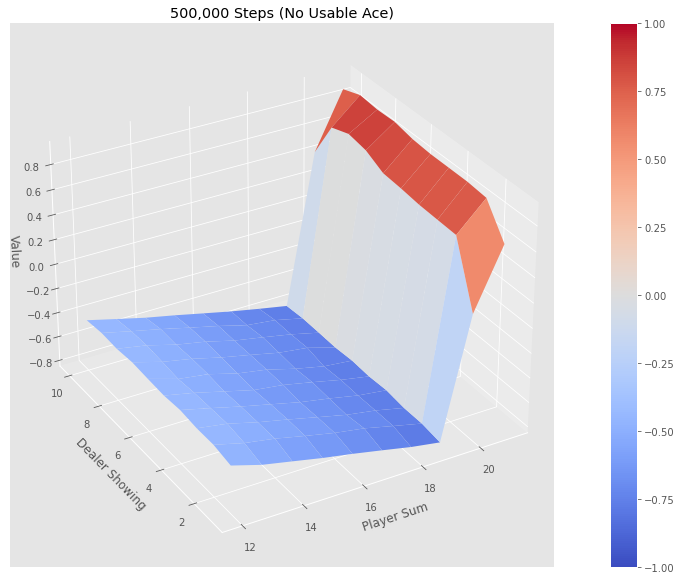

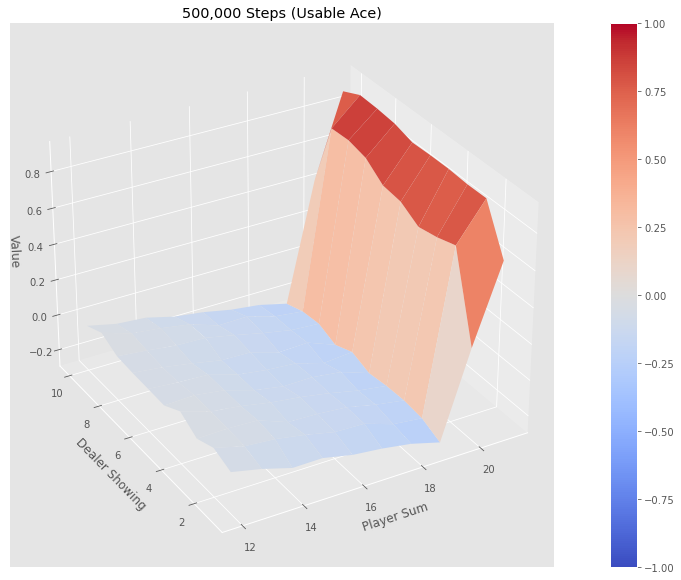


 41.99235960000078 s


C:\Users\filip\anaconda3\envs\edan95\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


In [12]:
start = time.clock()

V_10k = mc_prediction(sample_policy, env, num_episodes=10000,discount_factor=0.5)
plotting.plot_value_function(V_10k, title="10,000 Steps")
end = time.clock()
print("\n",end - start,"s")

start = time.clock()
V_500k = mc_prediction(sample_policy, env, num_episodes=500000,discount_factor=0.5)
plotting.plot_value_function(V_500k, title="500,000 Steps")
end = time.clock()
print("\n",end - start,"s")